In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Using TensorFlow backend.


In [2]:
from allennlp.data.tokenizers.word_tokenizer import WordTokenizer
from allennlp.modules.elmo import batch_to_ids

class Dataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
class EmoIntDataset(object):
    BASE_URL = "http://saifmohammad.com/WebDocs/"
    TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
    TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
    THRESHOLD = 0.33
  
    def get_labels(self):
        return ["anger", "fear", "joy", "sadness"]
  
    def get_label_map(self):
        return {label : i for i, label in enumerate(self.get_labels())}
    
    def _tokens_to_texts(self, tokens):
        texts = []
        for token in tokens:
            texts.append([t.text for t in token])
        return texts

    def _sequence_texts(self, texts):
        tokenizer = WordTokenizer()
        tokens = tokenizer.batch_tokenize(texts)
        sequences = batch_to_ids(self._tokens_to_texts(tokens))
        return sequences

    def __load_data_per_class(self, label, url, threshold=0):
        resource = urllib.request.urlopen(url)
        np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
        df = pd.DataFrame(np_array, columns=["id", "text", "label", "label_level"])
        df['label_level'] = df['label_level'].astype(float)
        df = df.query('label_level>' + str(threshold))
        df.loc[df["label"] == label, "label_int"] = self.get_label_map()[label]
        return df[["text", "label", "label_int"]]
    
    def __load_data(self, set_threshold=False):
        train_data = None
        test_data = None

        for label in self.get_labels():
            # load train dataset
            train_df = self.__load_data_per_class(label, self.BASE_URL + self.TRAIN_URI.format(label), threshold=(self.THRESHOLD if set_threshold else 0))

            # load test dataset
            test_df = self.__load_data_per_class(label, self.BASE_URL + self.TEST_URI.format(label), threshold=(self.THRESHOLD if set_threshold else 0))

            train_data = (train_df if train_data is None else train_data.append(train_df))
            test_data = (test_df if test_data is None else test_data.append(test_df))

        return train_data, test_data

    def __init__(self, set_threshold=False):
        train_data, test_data = self.__load_data(set_threshold)
        self.train_dataset = Dataset(self._sequence_texts(train_data.text).numpy(), train_data.label_int.values)
        self.test_dataset = Dataset(self._sequence_texts(test_data.text).numpy(), test_data.label_int.values)
        

In [3]:
dataset = EmoIntDataset(set_threshold=True)
X_train = dataset.train_dataset.X
y_train = dataset.train_dataset.y
X_test = dataset.test_dataset.X
y_test = dataset.test_dataset.y
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=41, stratify=y_train)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
print("X_train.shape: (%d, %d, %d)" % X_train.shape)
print("y_train.shape: (%d)" % y_train.shape)

print("X_valid.shape: (%d, %d, %d)" % X_valid.shape)
print("y_valid.shape: (%d)" % y_valid.shape)

print("X_test.shape: (%d, %d, %d)" % X_test.shape)
print("y_test.shape: (%d)" % y_test.shape)

X_train.shape: (2320, 85, 50)
y_train.shape: (2320)
X_valid.shape: (581, 85, 50)
y_valid.shape: (581)
X_test.shape: (2508, 44, 50)
y_test.shape: (2508)


In [5]:
np.save("pytorch_emoint_X_train_elmo.npy", X_train)
np.save("pytorch_emoint_X_valid_elmo.npy", X_valid)
np.save("pytorch_emoint_X_test_elmo.npy", X_test)

np.save("pytorch_emoint_y_train_elmo.npy", y_train)
np.save("pytorch_emoint_y_valid_elmo.npy", y_valid)
np.save("pytorch_emoint_y_test_elmo.npy", y_test)

In [6]:
X_train = np.load("pytorch_emoint_X_train_elmo.npy")
X_valid = np.load("pytorch_emoint_X_valid_elmo.npy")
X_test = np.load("pytorch_emoint_X_test_elmo.npy")

y_train = np.load("pytorch_emoint_y_train_elmo.npy")
y_valid = np.load("pytorch_emoint_y_valid_elmo.npy")
y_test = np.load("pytorch_emoint_y_test_elmo.npy")

In [7]:
dic = dataset.get_label_map()
labels = dataset.get_labels()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

class dictionary: {'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}
class labels: ['anger', 'fear', 'joy', 'sadness']
number of bins: 4


bins: [0, 1, 2, 3, 4]


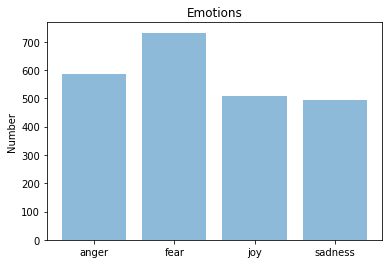

In [8]:
bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [9]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(y_train).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([2320, 1, 1, 1])
y_onehot.shape: torch.Size([2320, 7, 1, 1])


In [10]:
import torch
from torch.utils import data

class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, text, emotion, num_class=2):
    X = torch.LongTensor(text)
    y = torch.LongTensor(emotion).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [11]:
train_dataset = ISEAR_Tensor_Dataset(X_train, y_train, num_class=7)
valid_dataset = ISEAR_Tensor_Dataset(X_valid, y_valid, num_class=7)
test_dataset = ISEAR_Tensor_Dataset(X_test, y_test, num_class=7)

In [12]:
print("train_dataset.tensors[0].shape:", train_dataset.tensors[0].shape)
print("train_dataset.tensors[1].shape:", train_dataset.tensors[1].shape)

train_dataset.tensors[0].shape: torch.Size([2320, 85, 50])
train_dataset.tensors[1].shape: torch.Size([2320, 7])


In [13]:
print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

train_dataset length: 2320
valid_dataset length: 581
test_dataset length: 2508


In [14]:
batch_size = 50

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Load Elmo

In [15]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=2, dropout=0)
elmo = elmo.to(device)

In [16]:
shape = train_dataset[0][0].shape
print("shape:", shape)
experiment_X_train = train_dataset[0][0].view(1, shape[0], shape[1]).to(device)
print("experiment_X_train.shape:", experiment_X_train.shape)

embedded = elmo(experiment_X_train)
print("embedded shape:", embedded['elmo_representations'][0].shape)

shape: torch.Size([85, 50])
experiment_X_train.shape: torch.Size([1, 85, 50])
embedded shape: torch.Size([1, 85, 1024])


In [17]:
import scipy

sentences = [
  ["I", "ate", "an", "apple", "for", "breakfast"], 
  ["I", "ate", "a", "carrot", "for", "breakfast"]
]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids.to(device))
embeddings['elmo_representations'][0][0]

tensor([[-1.0646, -0.5283, -0.2031,  ..., -0.6870,  0.0331,  0.1069],
        [-0.2396, -0.1636,  0.6351,  ...,  0.4575,  0.2634,  0.6492],
        [ 0.0213, -0.4116, -0.1971,  ...,  0.0663, -0.3136,  0.5627],
        [ 0.7194, -0.4869,  0.8039,  ..., -0.1715,  0.2720,  1.1207],
        [-0.2111, -0.3582,  0.1580,  ..., -0.0863, -0.4251,  0.4566],
        [-0.3513, -0.3273,  0.4696,  ..., -0.0638, -0.3941,  0.4478]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [18]:
vector1 = embeddings['elmo_representations'][0][0].cpu().detach().numpy()
vector2 = embeddings['elmo_representations'][0][1].cpu().detach().numpy()
scipy.spatial.distance.cosine(vector1[3], vector2[3]) # cosine distance between "apple" and "carrot" in the last layer

0.27159833908081055

## Neural Network Architecture 

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ElmoClassifier(nn.Module):

    def __init__(self, device, elmo_embedding, input_dim, embedding_dim=1024, linear_dim=256,
                 output_dim=7, drop_rate=0.2):

        super(ElmoClassifier, self).__init__()
        
        self.device = device
        self.embedding = elmo_embedding
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.linear_dim = linear_dim
        self.output_dim = output_dim
        self.drop_rate = drop_rate
        
        self.linear = nn.Linear(in_features=self.embedding_dim, out_features=self.linear_dim)
        self.linear_pred = nn.Linear(in_features=self.linear_dim, out_features=self.output_dim)

    def __shape_to_string(self, shape):
        return str(shape)
    
    def summary(self, input_size):
        sentence = torch.LongTensor(np.zeros(input_size)).to(self.device)
        print("{:<20}  {:<25}".format("input", self.__shape_to_string(sentence.shape)))
        embeds = self.embedding(sentence)['elmo_representations'][0]
        print("{:<20}  {:<25}".format("embedding", self.__shape_to_string(embeds.shape)))
        avg_embeds = embeds.mean(dim=1)
        print("{:<20}  {:<25}".format("avg_embeds", self.__shape_to_string(avg_embeds.shape)))
        dense = self.linear(avg_embeds)
        print("{:<20}  {:<25}".format("dense", self.__shape_to_string(dense.shape)))
        output = F.softmax(self.linear_pred(dense))
        print("{:<20}  {:<25}".format("output", self.__shape_to_string(output.shape)))

    def forward(self, sentence):
        embeds = self.embedding(sentence)['elmo_representations'][0]
        avg_embeds = embeds.mean(dim=1)
        dense = F.dropout(self.linear(avg_embeds), self.drop_rate)
        output = F.softmax(self.linear_pred(dense))
        return output

In [20]:
input_dim = X_train.shape[1]
embedding_dim = 1024
linear_dim = 256
output_dim = 7
drop_rate = 0.2

model = ElmoClassifier(device, elmo, input_dim, embedding_dim, linear_dim, output_dim, drop_rate)
model = model.to(device)

model.summary([1, 201, 50])

input                 torch.Size([1, 201, 50]) 
embedding             torch.Size([1, 201, 1024])
avg_embeds            torch.Size([1, 1024])    
dense                 torch.Size([1, 256])     
output                torch.Size([1, 7])       


/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
train_loader.__dict__

{'dataset': <__main__.ISEAR_Tensor_Dataset at 0x7f64f5f2e0b8>,
 'batch_size': 50,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f637473d9e8>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f637473d860>,
 '_DataLoader__initialized': True}

In [22]:
def train(epoch, model, data_loader, device, optimiser, loss_fn=nn.BCELoss(), log_interval=100):
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()
    # model.hidden = model.init_hidden()
    
    train_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.data # sum up batch loss
        
        pred = output.max(1, keepdim=True)[1]
        pred = pred.view(pred.size(0))

        target = target.max(1, keepdim=True)[1]
        target = target.view(target.size(0))

        correct = pred.eq(target.view_as(pred)).sum()
        total_correct += correct

        all_pred += pred.cpu().numpy().tolist()
        all_target += target.cpu().numpy().tolist()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
    
    print('Train: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return train_loss, all_pred, all_target

In [23]:
def evaluate(model, data_loader, device, loss_fn=nn.BCELoss()):
    #####################
    # Evaluation model
    #####################
    model.eval()
    eval_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            eval_loss += loss_fn(output, target).data # sum up batch loss
            
            pred = output.max(1, keepdim=True)[1]
            pred = pred.view(pred.size(0))
            
            target = target.max(1, keepdim=True)[1]
            target = target.view(target.size(0))
            
            correct = pred.eq(target.view_as(pred)).sum()
            total_correct += correct

            all_pred += pred.cpu().numpy().tolist()
            all_target += target.cpu().numpy().tolist()

    print('Evaluate: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eval_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return eval_loss, all_pred, all_target

In [24]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 30
learning_rate = 1e-3
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_hist = np.zeros(max_epochs)
eval_loss_hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    train_loss, train_pred, train_target = train(epoch, model, train_loader, device, optimiser, loss_fn, log_interval)
    train_loss_hist[epoch] = train_loss
    
    valid_loss, valid_pred, valid_target = evaluate(model, valid_loader, device, loss_fn=nn.BCELoss())
    eval_loss_hist[epoch] = valid_loss

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0	/	2320	(0%)]	Loss: 0.408650
Train Epoch: 0 [500	/	2320	(21%)]	Loss: 0.337349
Train Epoch: 0 [1000	/	2320	(43%)]	Loss: 0.317932
Train Epoch: 0 [1500	/	2320	(64%)]	Loss: 0.314289
Train Epoch: 0 [2000	/	2320	(85%)]	Loss: 0.288815
Train: Average loss: 15.0849, Accuracy: 908/2320 (39%)
Evaluate: Average loss: 3.4595, Accuracy: 292/581 (50%)

Train Epoch: 1 [0	/	2320	(0%)]	Loss: 0.293373
Train Epoch: 1 [500	/	2320	(21%)]	Loss: 0.273797
Train Epoch: 1 [1000	/	2320	(43%)]	Loss: 0.281001
Train Epoch: 1 [1500	/	2320	(64%)]	Loss: 0.276030
Train Epoch: 1 [2000	/	2320	(85%)]	Loss: 0.283708
Train: Average loss: 12.9723, Accuracy: 1213/2320 (52%)
Evaluate: Average loss: 3.2185, Accuracy: 312/581 (53%)

Train Epoch: 2 [0	/	2320	(0%)]	Loss: 0.248006
Train Epoch: 2 [500	/	2320	(21%)]	Loss: 0.246156
Train Epoch: 2 [1000	/	2320	(43%)]	Loss: 0.242154
Train Epoch: 2 [1500	/	2320	(64%)]	Loss: 0.260514
Train Epoch: 2 [2000	/	2320	(85%)]	Loss: 0.235386
Train: Average loss: 11.8665, Accuracy: 

Evaluate: Average loss: 3.2724, Accuracy: 373/581 (64%)

Train Epoch: 23 [0	/	2320	(0%)]	Loss: 0.081108
Train Epoch: 23 [500	/	2320	(21%)]	Loss: 0.092252
Train Epoch: 23 [1000	/	2320	(43%)]	Loss: 0.110258
Train Epoch: 23 [1500	/	2320	(64%)]	Loss: 0.096347
Train Epoch: 23 [2000	/	2320	(85%)]	Loss: 0.078628
Train: Average loss: 4.7947, Accuracy: 2004/2320 (86%)
Evaluate: Average loss: 3.3522, Accuracy: 386/581 (66%)

Train Epoch: 24 [0	/	2320	(0%)]	Loss: 0.066044
Train Epoch: 24 [500	/	2320	(21%)]	Loss: 0.119964
Train Epoch: 24 [1000	/	2320	(43%)]	Loss: 0.069570
Train Epoch: 24 [1500	/	2320	(64%)]	Loss: 0.085363
Train Epoch: 24 [2000	/	2320	(85%)]	Loss: 0.136727
Train: Average loss: 4.9546, Accuracy: 1970/2320 (84%)
Evaluate: Average loss: 3.4152, Accuracy: 385/581 (66%)

Train Epoch: 25 [0	/	2320	(0%)]	Loss: 0.103594
Train Epoch: 25 [500	/	2320	(21%)]	Loss: 0.113260
Train Epoch: 25 [1000	/	2320	(43%)]	Loss: 0.057329
Train Epoch: 25 [1500	/	2320	(64%)]	Loss: 0.100571
Train Epoch: 25 [200

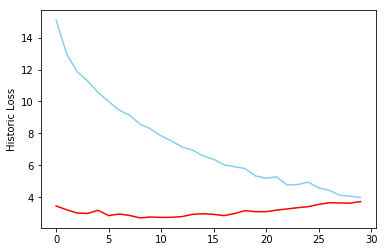

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, color='skyblue')
plt.plot(eval_loss_hist, color='red')
plt.ylabel('Historic Loss')
plt.show()

In [26]:
model_path = 'pytorch_emoint_dense_elmo_model.h5'
weight_path = 'pytorch_emoint_dense_elmo_weights.h5'

torch.save(model.state_dict(), weight_path)
torch.save(model, model_path)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ElmoClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
test_loss, test_pred, test_target = evaluate(model, test_loader, device, loss_fn)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate: Average loss: 37.4274, Accuracy: 1400/2508 (55%)



In [28]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_target, test_pred)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,fear,joy,sadness
anger,373,74,68,128
fear,155,338,86,210
joy,43,38,396,66
sadness,74,96,70,293


In [29]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


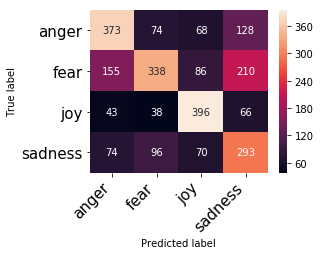

In [30]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [31]:
test_accuracy = accuracy_score(test_target, test_pred)
print("test accuracy:", test_accuracy)

test accuracy: 0.5582137161084529


### Performance score for each classes

In [32]:
precision, recall, fscore, support = precision_recall_fscore_support(test_target, test_pred)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.5783,0.5801,0.5792,643
fear,0.6190,0.4284,0.5064,789
joy,0.6387,0.7293,0.6810,543
sadness,0.4204,0.5497,0.4764,533


In [34]:
precision, recall, fscore, support = precision_recall_fscore_support(test_target, test_pred, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5582,0.5582,0.5582,None


### Cohen Kappa Score

In [35]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_target, test_pred)
print("kappa:", kappa_score)

kappa: 0.4132929536392186
